# Machine Learning Bootcamp Project - Korelasyon Matrisi, Özellik Seçimi, Sınıfların Dengesizliği, Karar Ağaçları, Kesinlik/Duyarlılık/F1 Skoru
Merhabalar, Projemizde İtalyan deprem kataloğunda şu maddelere yer verdik


*   Veri Ön İşleme ve Anlama
*   Hedef Değişkenin Tanımlanması

*   Sınıfların Dengesizliği (Class Imbalance)
*   Korelasyon Matrisi


*   Özellik Seçimi (Feature Selection)
*   Karar Ağaçları (Decision Trees)

*   Kesinlik / Duyarlılık / F1 Skoru (Precision / Recall / F1-Score)

Bu adımları izleyerek veri setimiz üzerinde kapsamlı bir analiz gerçekleştirebilir ve belirtilen konuları ele alabiliriz.

Şimdi, veri ön işleme, hedef değişken oluşturma ve korelasyon matrisi adımlarıyla başlayabiliriz.

Öncelikle temel kütüphanelerimizi import ederek başlıyoruz.









In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Italian_Catalogue.csv')

Bu projede, İtalyan deprem kataloğunu analiz ederek sismik örüntüleri anlamak, deprem özelliklerini tahmin etmek için ilgili özellikleri seçmek ve bir sınıflandırma modeli oluşturmaktır. Kullandığımız veri setine https://www.kaggle.com/datasets/die9origephit/italian-earthquake-catalogue-1985-2020 adresinden ulaşabilirsiniz.


İlk Bölüme Keşifsel Veri Analizi kısmıyla başlıyoruz.

# Nümerik EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181777 entries, 0 to 181776
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         181777 non-null  int64  
 1   #EventID           181777 non-null  int64  
 2   Time               181777 non-null  object 
 3   Latitude           181777 non-null  float64
 4   Longitude          181777 non-null  float64
 5   Depth/Km           181777 non-null  float64
 6   Author             181777 non-null  object 
 7   MagType            181777 non-null  object 
 8   Magnitude          181777 non-null  float64
 9   EventLocationName  181777 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 13.9+ MB


Veri kümemiz 181777 satır ve 10 sütundan oluşuyor. İlk 9 özelliği öğreneceğiz, eğer işimize yaramayacak bir özellik ile karşılaşırsak onu çıkartarak işlemlerimize devam edeceğiz.

# Gereksiz Sütunların Kaldırılması

Unnamed: 0 ve #EventID gibi tanımlayıcı olan ve modelleme adına faydalı olmayan bu sütunlar kaldırıldı.

In [4]:
df.drop(['Unnamed: 0', '#EventID'], axis=1, inplace=True)

# Zaman Verisinin Dönüştürülmesi ve EventLocationName özelliğinin  çıkartılması

Time sütunu datetime nesnelerine dönüştürülerek yıl, ay, gün, saat gibi faydalı özellikler oluşturuyoruz. Bu, zamansal desenleri analiz etmemize yardımcı oluyor.

In [5]:
df['Time'] = pd.to_datetime(df['Time'])
df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df['Hour'] = df['Time'].dt.hour


In [6]:
if 'EventLocationName' in df.columns:
    df.drop(['EventLocationName'], axis=1, inplace=True, errors='ignore')

# Sınıflandırma
Sınıflandırma yapabilmek için bir hedef değişkene ihtiyacımız oldu. Magnitude (Büyüklük) sütununu kullanarak depremleri kategorilere ayıracağız.

In [7]:
def classify_magnitude(mag):  #Sınıflandırma
    if mag < 2.0:
        return "Low"
    elif mag < 3.0:
        return "Medium"
    else:
        return "High"

df["MagnitudeClass"] = df["Magnitude"].apply(classify_magnitude)

Kodumuzu incelemek gerekirse 2.0 dan küçük değerlere low, 3.0 dan küçük değerlere medium, geri kalanlara ise high class'ını atadık.

# Sınıfların Dengesizliği

Atadığımız sınıfların toplam değerlerine bakmamız gerekiyor çünkü bir sınıf dengesizliğiyle karşılaşma ihtimalimiz var.

In [23]:
print(df["MagnitudeClass"].value_counts())

MagnitudeClass
Low       87590
Medium    82993
High      11194
Name: count, dtype: int64


Kod çıktısına baktığımız zaman bir sınıf dengesizliği olduğunu fark ediyoruz ve bu sorunun high parametresinden kaynaklandığını görüyoruz. Sorunu ortadan kaldırmak için high class'ını veri seti içinden çıkartmamız gerekiyor.

In [24]:
df_filtered = df[df["MagnitudeClass"] != "High"].copy()

Kalan sütunlara numerical bir hal kazandırmak için binary numarası eklememiz gerekiyor.

In [21]:
df_filtered["MagnitudeClass"]  = df_filtered["MagnitudeClass"].map({"Low": 0, "Medium": 1})

In [25]:
print(df_filtered["MagnitudeClass"].value_counts())

MagnitudeClass
Low       87590
Medium    82993
Name: count, dtype: int64


# Korelasyon Matrisi

Sayısal özellikler (Latitude, Longitude, Depth/Km, Magnitude, Year, Month, Day, Hour) arasındaki doğrusal ilişkileri incelemek için bir korelasyon matrisi oluşturduk ve görselleştirdik.

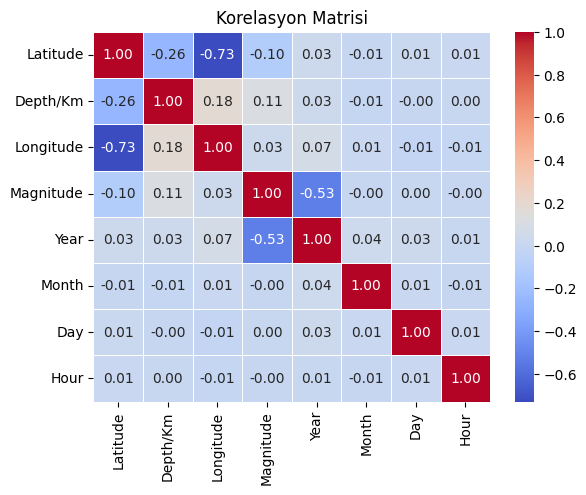

In [26]:
corr_matrix = df_filtered[["Latitude", "Depth/Km","Longitude", "Magnitude",'Year', 'Month', 'Day', 'Hour']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Korelasyon Matrisi")
plt.show()



*   Magnitude ile Year arasında orta derecede negatif bir korelasyon (-0.49) olduğunu görüyoruz. Bu, yıllar geçtikçe kaydedilen ortalama deprem büyüklüklerinde bir azalma olabileceğine işaret edebilir.
*   Latitude ve Longitude arasında güçlü bir negatif korelasyon (-0.71) görebiliriz; bu, İtalya'nın coğrafi yapısıyla ilgilidir.



In [27]:
print("\nKorelasyon Matrisi:")
print(abs(corr_matrix))


Korelasyon Matrisi:
           Latitude  Depth/Km  Longitude  Magnitude      Year     Month  \
Latitude   1.000000  0.255239   0.729590   0.103081  0.028043  0.005259   
Depth/Km   0.255239  1.000000   0.177638   0.110160  0.032919  0.007441   
Longitude  0.729590  0.177638   1.000000   0.029589  0.074148  0.009273   
Magnitude  0.103081  0.110160   0.029589   1.000000  0.526835  0.000073   
Year       0.028043  0.032919   0.074148   0.526835  1.000000  0.038164   
Month      0.005259  0.007441   0.009273   0.000073  0.038164  1.000000   
Day        0.013990  0.001199   0.013797   0.002271  0.029713  0.012543   
Hour       0.013155  0.001490   0.011003   0.003118  0.005515  0.005200   

                Day      Hour  
Latitude   0.013990  0.013155  
Depth/Km   0.001199  0.001490  
Longitude  0.013797  0.011003  
Magnitude  0.002271  0.003118  
Year       0.029713  0.005515  
Month      0.012543  0.005200  
Day        1.000000  0.009045  
Hour       0.009045  1.000000  


Yukarıda korelasyon matrisinin mutlak verilerini görebilirsiniz. Burada incelediğimiz veriler üzerinden düşük korelasyon tespiti yapacağız.

In [28]:
cor_target = abs(corr_matrix["Magnitude"])
relevant_features = cor_target[cor_target>0.1]
relevant_features

,Magnitude
Latitude,0.103081
Depth/Km,0.110160
Magnitude,1.000000
Year,0.526835


Mutlak verilerini incelediğimiz matris üzerinden 0.1'den düşük olan değerleri çıkartmaya karar verdik. Kullandığımız kod ile bu özelliklerin analizden çıkartılmasını sağladık. Kalan değerler yukarıda görüldüğü gibidir.

# Özellik Seçimi, Karar Ağaçları ve Değerlendirme (İlk Deneme ve Veri Sızıntısı Tespiti)

Modeli oluştururken Author ve MagType gibi kategorik özellikleri one-hot encoding yöntemiyle, Hedef değişken olan Magnitude_Class'ı ise Label Encoding ile sayısallaştıracağız. Ama hepsinden önce işe modelleme kütüphanelerimizi ekleyerek başlıyoruz.








In [30]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [50]:
label_encoder = LabelEncoder() #Label Encoding part
df_filtered['MagnitudeClass_Encoded'] = label_encoder.fit_transform(df_filtered['MagnitudeClass'])

In [70]:
numerical_features_corrected = ['Latitude', 'Longitude', 'Depth/Km', 'Year', 'Month', 'Day', 'Hour']
categorical_features = ['Author', 'MagType'] #one-hot encoding part

df_filtered_encoded = pd.get_dummies(df_filtered, columns=categorical_features, drop_first=True)

İlk modelleme denemesinde, elde edilen sonuçlar şaşırtıcı derecede mükemmeldi:

*   En önemli özellik açık ara farkla Magnitude (Büyüklük) olarak bulundu (Önem skoru: 1.0). Diğer tüm özelliklerin önemi neredeyse sıfırdı.
*   Tüm sınıflar için kesinlik, duyarlılık ve F1 skoru 1.00 olarak hesaplandı.

Bu nokta sonuçlar, tipik olarak veri sızıntısının işaretidir. Model, hedef değişkeni oluşturmak için doğrudan kullanılan veya hedef değişken hakkında bilgi içeren bir özelliği eğitim sırasında görmüştür. Bu durumda, Magnitude_Class hedef değişkeni Magnitude sütunundan türetildiği için, Magnitude sütununun modelde bir özellik olarak kullanılması veri sızıntısına yol açmıştır.

Bu nedenle, Magnitude özelliği modelden çıkartıyoruz ve analizi tekrarlıyoruz.

In [71]:
features_to_use_corrected = numerical_features_corrected + \
                            [col for col in df_filtered_encoded.columns if any(cat_feat in col for cat_feat in categorical_features)]


In [73]:
features_to_use_corrected = [
    feat for feat in features_to_use_corrected
    if feat not in ['Time', 'Magnitude_Class', 'Magnitude_Class_Encoded', 'Magnitude']
]

In [75]:
X = df_filtered_encoded[features_to_use_corrected]
y = df_filtered_encoded['MagnitudeClass_Encoded'] #Hedef değişkenimiz aynı

In [76]:
print(f"\nX (düzeltilmiş özellikler) boyutu: {X.shape}")
print(f"Kullanılan düzeltilmiş özellikler: {X.columns.tolist()}")


X (düzeltilmiş özellikler) boyutu: (170583, 23)
Kullanılan düzeltilmiş özellikler: ['Latitude', 'Longitude', 'Depth/Km', 'Year', 'Month', 'Day', 'Hour', 'Author_BULLETIN-INGV', 'Author_BULLETIN-INGV-A', 'Author_BULLETIN-OV', 'Author_BULLETIN-SISPICK', 'Author_BULLETIN-VAX', 'Author_CSEM', 'Author_REMO-INGV', 'Author_SED', 'Author_SURVEY-INGV', 'Author_SURVEY-INGV-CT', 'Author_SURVEY-INGV-OV', 'Author_SURVEY-INGV-OV#WinPick', 'MagType_ML', 'MagType_Md', 'MagType_Mw', 'MagType_mb']


Yukarıda veri sızıntısından sonra düzenlediğimiz yeni değişkenlerin boyutu ve özelliklerini görebiliriz.

# K-FOLD kullanarak Model Seçimi

Bu yöntem, modelin performansını tek bir eğitim-test bölünmesine göre daha güvenilir bir şekilde tahmin etmemize yardımcı olur. Daha doğru bir sonuç için veri setindeki dengesizlikleri de göz önünde bulunduran StratifiedKFold kullanmayı da tercih ettik.

In [77]:
dt_classifier = DecisionTreeClassifier(random_state=42, min_samples_leaf=5)

Bu kod ile karar ağacı sınıflandırıcısını tanımlamasını istiyorum ve min_samples kullanarak aşırı uydurmanın önüne geçmiş bulunuyoruz.

In [78]:
n_splits = 5 # Katlama sayısı (genellikle 5 veya 10 kullanılır.)
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [79]:
scoring_metric = 'accuracy'
cv_scores = cross_val_score(dt_classifier, X, y, cv=skf, scoring=scoring_metric)

'accuracy' her sınıf için F1 skorunu hesaplıyor ve her sınıfın örnek sayısına göre ağırlıklı ortalamasını alıyor. Şimdi K-FOLD ile oluşan accuracy değerlerine bakalım.

In [80]:
print(f"\n{n_splits}-Katlamalı Çapraz Doğrulama ile {scoring_metric} skorları:")
for i, score in enumerate(cv_scores):
    print(f"Katlama {i+1}: {score:.4f}")


5-Katlamalı Çapraz Doğrulama ile accuracy skorları:
Katlama 1: 0.7600
Katlama 2: 0.7579
Katlama 3: 0.7600
Katlama 4: 0.7617
Katlama 5: 0.7598


In [81]:
print(f"\nOrtalama {scoring_metric}: {cv_scores.mean():.4f}")
print(f"Standart Sapma {scoring_metric}: {cv_scores.std():.4f}")


Ortalama accuracy: 0.7599
Standart Sapma accuracy: 0.0012


Detaylı raporlama için hepsini içerecek sınıflandırma raporu adında tek bir bölüm tasarlayalım.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
dt_classifier.fit(X_train, y_train) #Modeli eğitim verisi üzerinde eğitiyoruz.

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [84]:
y_pred = dt_classifier.predict(X_test) #Test seti üzerinde tahmin yaptırıyoruz.

In [85]:
print("\nSınıflandırma Raporu (Tek Eğitim-Test Bölümü):")
target_names_sorted = [name for _, name in sorted(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))]
print(classification_report(y_test, y_pred, target_names=target_names_sorted, zero_division=0))


Sınıflandırma Raporu (Tek Eğitim-Test Bölümü):
              precision    recall  f1-score   support

         Low       0.76      0.77      0.76     17544
      Medium       0.75      0.74      0.74     16573

    accuracy                           0.76     34117
   macro avg       0.76      0.75      0.75     34117
weighted avg       0.76      0.76      0.75     34117



# Confusion Matrix'ini oluşturma

In [86]:
cm_labels_indices = label_encoder.transform(label_encoder.classes_)
cm = confusion_matrix(y_test, y_pred, labels=cm_labels_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names_sorted)

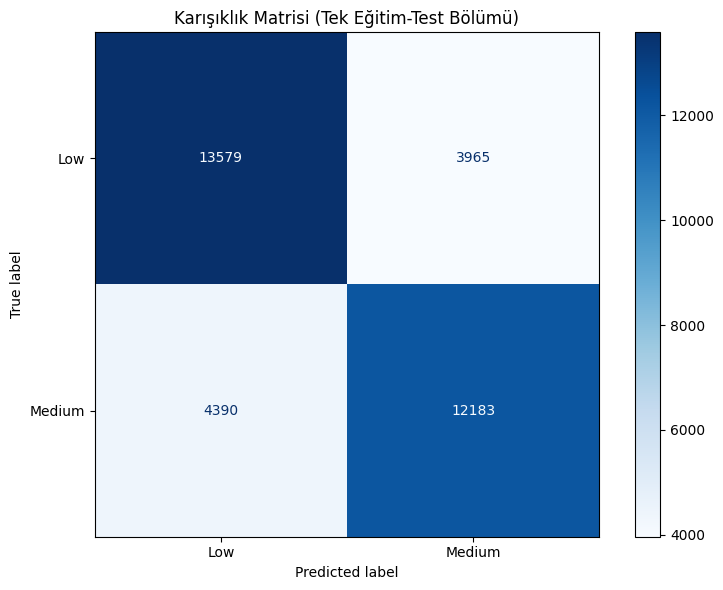

In [87]:
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Karışıklık Matrisi (Tek Eğitim-Test Bölümü)')
plt.tight_layout()
plt.show()

Confusion matrix oluşan değerler bize yapay zekanın gerçekleşen 17544 tane düşük şiddetli depremlerin 13579 adetini doğru hesaplamıştır bu da bize 0.76 lık bir doğruluk payı verir bu da bulduğumuz accuracy değeriyle aynıdır.

# Karar Ağacının bir kısmının görselleştirilmesi

Analizimizde de plot_tree fonksiyonu içinde max_depth=3 gibi bir parametre kullanarak ağacın sadece ilk 3 seviyesini çizdirdik. Bu, ağacın temel yapısını ve ilk karar noktalarını net bir şekilde görebilmemizi sağlıyor, aksi takdirde yüzlerce düğümden oluşan karmaşık bir görüntüyle karşılaşırdık.

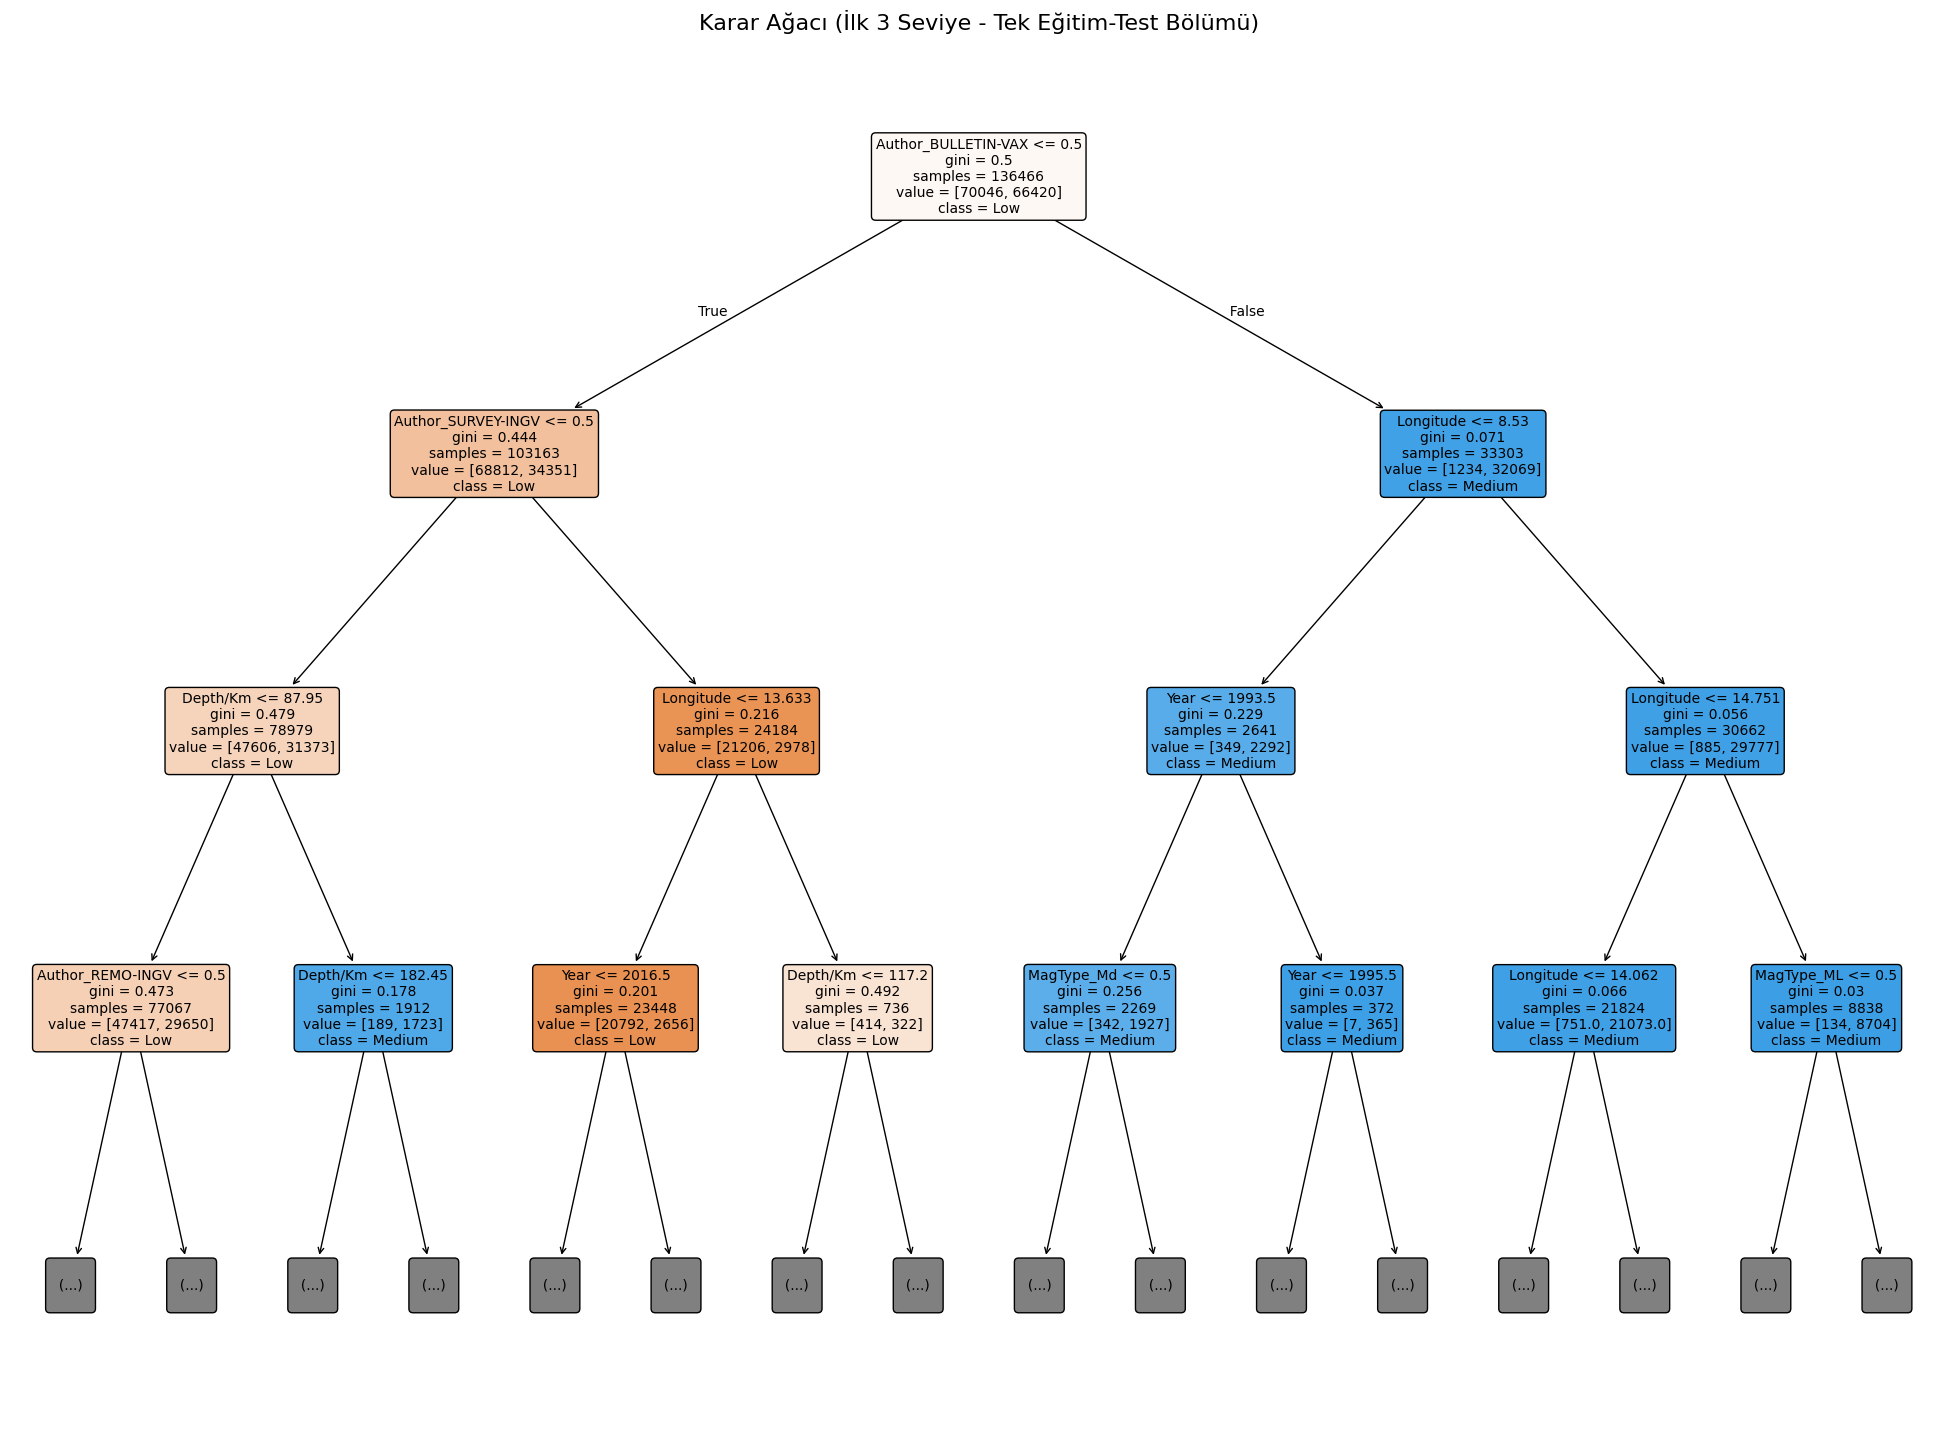

In [88]:
plt.figure(figsize=(25,18))
plot_tree(dt_classifier,
          feature_names=X.columns.tolist(),
          class_names=target_names_sorted,
          filled=True,
          rounded=True,
          proportion=False,
          max_depth=3,
          fontsize=10,
          impurity=True,
          label='all'
         )
plt.title("Karar Ağacı (İlk 3 Seviye - Tek Eğitim-Test Bölümü)", fontsize=16)
plt.show()